Este código toma como entrada los datos crudos, y en lugar de dividir en folds, arma un Dataset por sujeto. Luego puedo unir los dataset.

Puedo hacerlo para un sujeto puntual o para todos, con reposo o sin, y con sample weights.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/My Drive/repo_tesis/entorno_tesis_Molina"
!source bin/activate

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1p7dFFKqLvO4o4GAmIQpnbXVWvt_2Dv-l/repo_tesis/entorno_tesis_Molina


In [ ]:
import numpy as np
import pickle
import joblib
import pandas as pd
import sys
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight

# Levanto los datos del Experimento 1

In [ ]:
%cd "/content/drive/My Drive/repo_tesis/src/ronda_experimentos_2/datos_crudos2dataset"
# Load data
file = open('MyoArmband_data_exp1_cor.pickle', 'rb')
MyoArm_data = pickle.load(file)
file.close()

/content/drive/.shortcut-targets-by-id/1p7dFFKqLvO4o4GAmIQpnbXVWvt_2Dv-l/repo_tesis/src/ronda_experimentos_2/datos_crudos2dataset


## Extracción de datos

In [ ]:
# Extraigo frecuencia de muestreo
fs = MyoArm_data['S1']['info']['fs'] # Frecuency in Hz

nOfSubjects = 10 # N° of Subjects [1,...,10]- cantidad de sujetos con lo que voy a trabajar
nChannels = 16 # N° of Channels- numero de canales con los que quiero trabajar- el maximo es MyoArm_data['S1']['emg'].shape[1]+1

data_list = []  # en cada elemento de la lista guardo los datos de un sujeto, luego los concateno
label_list = [] # lo mismo que para la anterior
subject_list = []   # aqui se indica a que sujeto pertenece la senal a lo largo del tiempo


for i in range(1, nOfSubjects+1):
    data_list.append(MyoArm_data['S'+str(i)]['emg'])
    label_list.append(MyoArm_data['S'+str(i)]['label'])
    subject_list.append(MyoArm_data['S'+str(i)]['label']*0 + i)

# Ahora tengo que concatenar los elementos de la lista
data = []
label = []
subject = []
for i in range(len(data_list)):
    data.extend(data_list[i])
    label.extend(label_list[i])
    subject.extend(subject_list[i])

data = np.array(data)
label = np.array(label)
subject = np.array(subject)

# Selección de secuencias

In [ ]:
# hago una lista de Dataframes
list_data_x_sujeto = []
list_label_x_sujeto = []

for i in range(1, nOfSubjects+1):  # luego podría no hardcodearlo
  ind_sujeto_act = np.where(subject==i)[0]
  list_data_x_sujeto.append(data[ind_sujeto_act])
  list_label_x_sujeto.append(label[ind_sujeto_act])

## Para un sujeto puntual

In [ ]:
j = 0 # elijo el sujeto

label_j = list_label_x_sujeto[j]
data_j = list_data_x_sujeto[j]

input_sequence_length = 500 # Cada gesto dura 5s aprox, y el incremento es de 50ms

label_dataset = tf.keras.utils.timeseries_dataset_from_array(
        data=label_j,  # excluimos los últimos target_sequence_length elementos de los datos
        targets=None,
        sequence_length=input_sequence_length,
        batch_size=None,   # multiplo de 8
        sequence_stride = 50
      )
data_dataset = tf.keras.utils.timeseries_dataset_from_array(
        data=data_j,  # excluimos los últimos target_sequence_length elementos de los datos
        targets=None,
        sequence_length=input_sequence_length,
        batch_size=None,   # multiplo de 8
        sequence_stride = 50
      )

In [ ]:
secuencias_labels_list = []
secuencias_data_list = []

for x in label_dataset:
  secuencias_labels_list.append(x)

for x in data_dataset:
  secuencias_data_list.append(x)

In [ ]:
selected_secuencias_labels_list = []
selected_secuencias_data_list = []

contador_reposos = 0

for i in range(len(secuencias_labels_list)):  # len(secuencias_labels_list)
  unique_values, counts = np.unique(secuencias_labels_list[i], return_counts=True)
  # Encontrar el valor que más se repite
  max_count_index = np.argmax(counts)
  most_frequent_value = unique_values[max_count_index]
  counts_most_frequent = counts[max_count_index]

  if most_frequent_value==0:
    contador_reposos += 1

  if (((counts_most_frequent/len(secuencias_labels_list[i])) > 0.85) and (most_frequent_value != 0)):
    selected_secuencias_labels_list.append(secuencias_labels_list[i])
    selected_secuencias_data_list.append(secuencias_data_list[i])

In [ ]:
contador_reposos

1550

(array([27., 26., 25., 24., 29., 28., 27., 28., 25., 27., 27., 23.]),
 array([ 1.        ,  1.91666667,  2.83333333,  3.75      ,  4.66666667,
         5.58333333,  6.5       ,  7.41666667,  8.33333333,  9.25      ,
        10.16666667, 11.08333333, 12.        ]),
 <BarContainer object of 12 artists>)

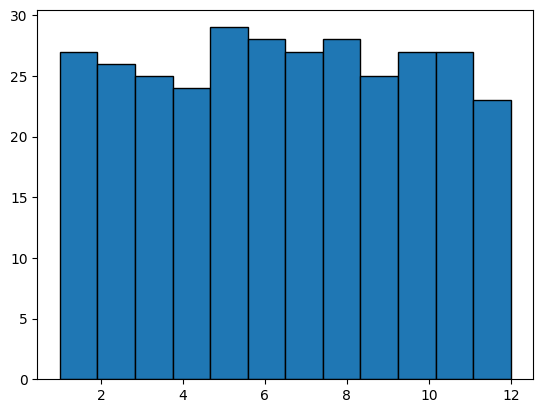

In [ ]:
plt.hist(np.array(selected_secuencias_labels_list), bins=12, edgecolor='black')

In [ ]:
selected_secuencias_labels_array = np.array(selected_secuencias_labels_list)

In [ ]:
np.max(selected_secuencias_labels_array)

12

## Armo el dataset para cada sujeto

### Sin reposo

In [ ]:
# para cada sujeto armo un Dataset con las secuencias de datos y etiquetas
list_input_dataset_x_sujeto = []
list_labels_dataset_x_sujeto = []

for j in range(0, 10):  #
  label_j = list_label_x_sujeto[j]
  data_j = list_data_x_sujeto[j]

  input_sequence_length = 650 # Cada gesto dura 5s aprox, y el incremento es de 50ms

  label_dataset = tf.keras.utils.timeseries_dataset_from_array(
          data=label_j,  # excluimos los últimos target_sequence_length elementos de los datos
          targets=None,
          sequence_length=input_sequence_length,
          batch_size=None,   # multiplo de 8
          sequence_stride = 5
        )
  data_dataset = tf.keras.utils.timeseries_dataset_from_array(
          data=data_j,  # excluimos los últimos target_sequence_length elementos de los datos
          targets=None,
          sequence_length=input_sequence_length,
          batch_size=None,   # multiplo de 8
          sequence_stride = 5
        )

  secuencias_labels_list = []
  secuencias_data_list = []

  for x in label_dataset:
    secuencias_labels_list.append(x)

  for x in data_dataset:
    secuencias_data_list.append(x)

  selected_secuencias_labels_list = []
  selected_secuencias_data_list = []

  contador_reposos = 0

  for i in range(len(secuencias_labels_list)):  # len(secuencias_labels_list)
    unique_values, counts = np.unique(secuencias_labels_list[i], return_counts=True)
    # Encontrar el valor que más se repite
    max_count_index = np.argmax(counts)
    most_frequent_value = unique_values[max_count_index]
    counts_most_frequent = counts[max_count_index]

    if most_frequent_value==0:
      contador_reposos += 1

    if (((counts_most_frequent/len(secuencias_labels_list[i])) == 1) and (most_frequent_value != 0)):
      selected_secuencias_labels_list.append(np.array(secuencias_labels_list[i]))
      selected_secuencias_data_list.append(secuencias_data_list[i])

  selected_secuencias_labels_array = np.array(selected_secuencias_labels_list) - 1
  # Convertir las listas en tensores de TensorFlow
  tensores = tf.stack(selected_secuencias_data_list)
  etiquetas = tf.convert_to_tensor(list(selected_secuencias_labels_array))

  # # Visualizar cantidad de cada clase
  # plt.figure()
  # plt.hist(np.array(selected_secuencias_labels_list), bins=17, edgecolor='black')
  # plt.title('Cantidad de cada clase para el sujeto'+str(j))

  # Crear un dataset a partir de los tensores y etiquetas
  input_dataset = tf.data.Dataset.from_tensor_slices((tensores, etiquetas))

  input_dataset.save("2025_dataset_E1_sin_reposo_crudo_sub"+str(j)+"_seq_seq")
# ----------------------------------------------------------------------------------------------------
#   # esto seguro se puede hacer mejor
#   sec_label_i = []
#   for x, y in input_dataset:
#     sec_label_i.append(np.mean(y))  # todos los valores de las secuencias son iguales

#   unique_values, counts = np.unique(np.array(sec_label_i), return_counts=True)

#   tope = np.min(np.array(counts))
#   # plt.figure()
#   # plt.title('Sujeto '+str(j))
#   # plt.hist(sec_label_i, edgecolor='black')

# #-------- VUELVO A HACER TODO SABIENDO CUAL ES EL MINIMO. ESTO SE PUEDE HACER MEJOR SEGURO ------------

#   selected_secuencias_labels_list = []
#   selected_secuencias_data_list = []

#   contador_reposos = 0

#   contador_labels = np.zeros(12, dtype=int)

#   for i in range(len(secuencias_labels_list)):  # len(secuencias_labels_list)
#     unique_values, counts = np.unique(secuencias_labels_list[i], return_counts=True)
#     # Encontrar el valor que más se repite
#     max_count_index = np.argmax(counts)
#     most_frequent_value = unique_values[max_count_index]
#     counts_most_frequent = counts[max_count_index]

#     if most_frequent_value==0:
#       contador_reposos += 1

#     if (((counts_most_frequent/len(secuencias_labels_list[i])) == 1) and (most_frequent_value != 0) and (contador_labels[most_frequent_value-1]<tope)):
#       # print(most_frequent_value)
#       contador_labels[most_frequent_value-1] += 1
#       # print(contador_labels)
#       selected_secuencias_labels_list.append(np.array(secuencias_labels_list[i]))
#       selected_secuencias_data_list.append(secuencias_data_list[i])

#   selected_secuencias_labels_array = np.array(selected_secuencias_labels_list) - 1
#   # Convertir las listas en tensores de TensorFlow
#   tensores = tf.stack(selected_secuencias_data_list)
#   etiquetas = tf.convert_to_tensor(list(selected_secuencias_labels_array))

#   # # Visualizar cantidad de cada clase
#   # plt.figure()
#   # plt.hist(np.array(selected_secuencias_labels_list), bins=12, edgecolor='black')
#   # plt.title('Cantidad de cada clase para el sujeto'+str(j))

#   # Crear un dataset a partir de los tensores y etiquetas
#   input_dataset = tf.data.Dataset.from_tensor_slices((tensores, etiquetas))

#   # esto seguro se puede hacer mejor
#   sec_label_i = []
#   for x, y in input_dataset:
#     sec_label_i.append(np.mean(y))  # todos los valores de las secuencias son iguales

#   unique_values, counts = np.unique(np.array(sec_label_i), return_counts=True)

#   # plt.figure()
#   # plt.title('Sujeto '+str(j))
#   # plt.hist(sec_label_i, bins = 12, edgecolor='black')

#   # Guardar el dataset
#   # input_dataset.save("dataset_E1_E2_E3_selected_sin_reposo_crudo_sub"+str(j)+"_seq_seq")

In [ ]:
counts

array([45, 37, 32, 38, 50, 50, 48, 50, 34, 42, 49, 41])

### Con reposo

In [ ]:
%cd "/content/drive/My Drive/repo_tesis/src/ronda_experimentos_2/datos_crudos2dataset"
# para cada sujeto armo un Dataset con las secuencias de datos y etiquetas

list_input_dataset_x_sujeto = []
list_labels_dataset_x_sujeto = []

for j in range(nOfSubjects):
  label_j = list_label_x_sujeto[j]
  data_j = list_data_x_sujeto[j]

  input_sequence_length = 650 # Cada gesto dura 5s aprox, y el incremento es de 50ms

  label_dataset = tf.keras.utils.timeseries_dataset_from_array(
          data=label_j,  # excluimos los últimos target_sequence_length elementos de los datos
          targets=None,
          sequence_length=input_sequence_length,
          batch_size=None,   # multiplo de 8
          sequence_stride = 5
        )
  data_dataset = tf.keras.utils.timeseries_dataset_from_array(
          data=data_j,  # excluimos los últimos target_sequence_length elementos de los datos
          targets=None,
          sequence_length=input_sequence_length,
          batch_size=None,   # multiplo de 8
          sequence_stride = 5
        )

  secuencias_labels_list = []
  secuencias_data_list = []

  for x in label_dataset:
    secuencias_labels_list.append(x)

  for x in data_dataset:
    secuencias_data_list.append(x)

  selected_secuencias_labels_list = []
  selected_secuencias_data_list = []

  contador_reposos = 0

  for i in range(len(secuencias_labels_list)):  # len(secuencias_labels_list)
    unique_values, counts = np.unique(secuencias_labels_list[i], return_counts=True)
    # Encontrar el valor que más se repite
    max_count_index = np.argmax(counts)
    most_frequent_value = unique_values[max_count_index]
    counts_most_frequent = counts[max_count_index]

    if most_frequent_value==0:
      contador_reposos += 1

    if (((counts_most_frequent/len(secuencias_labels_list[i])) > 0.85)): #
      if (most_frequent_value==0):
        if (contador_reposos<350):
          contador_reposos += 1
          selected_secuencias_labels_list.append(np.array(secuencias_labels_list[i]))
          selected_secuencias_data_list.append(secuencias_data_list[i])
      else:
        selected_secuencias_labels_list.append(np.array(secuencias_labels_list[i]))
        selected_secuencias_data_list.append(secuencias_data_list[i])

  # selected_secuencias_labtensor(selected_secuencias_labels_list)
  # # Visualizar cantidad de cada clase
  # plt.figure()
  # plt.hist(np.array(selected_secuencias_labels_list), bins=13, edgecolor='black')
  # plt.title('Cantidad de cada clase para el sujeto'+str(j))

  # selected_secuencias_labels_array = np.array(selected_secuencias_labels_list)
  # Convertir las listas en tensores de TensorFlow
  tensores = tf.stack(selected_secuencias_data_list)
  # etiquetas = tf.convert_to_tensor(list(selected_secuencias_labels_array))
  etiquetas = tf.convert_to_tensor(selected_secuencias_labels_list)

  # Crear un dataset a partir de los tensores y etiquetas
  input_dataset = tf.data.Dataset.from_tensor_slices((tensores, etiquetas))

  # Guardar el dataset
  input_dataset.save("dataset_E1_selected_con_reposo_crudo_sub"+str(j)+"_seq_seq")

/content/drive/.shortcut-targets-by-id/1p7dFFKqLvO4o4GAmIQpnbXVWvt_2Dv-l/repo_tesis/src/ronda_experimentos_2/datos_crudos2dataset


### Con sample weight sin reposo

#### Calculo de pesos

In [ ]:
selected_secuencias_labels_list_x_sujeto = []

for j in range(nOfSubjects): # ,
  label_j = list_label_x_sujeto[j]
  data_j = list_data_x_sujeto[j]

  input_sequence_length = 650 # Cada gesto dura 5s aprox, y el incremento es de 50ms

  label_dataset = tf.keras.utils.timeseries_dataset_from_array(
          data=label_j,  # excluimos los últimos target_sequence_length elementos de los datos
          targets=None,
          sequence_length=input_sequence_length,
          batch_size=None,   # multiplo de 8
          sequence_stride = 5
        )
  data_dataset = tf.keras.utils.timeseries_dataset_from_array(
          data=data_j,  # excluimos los últimos target_sequence_length elementos de los datos
          targets=None,
          sequence_length=input_sequence_length,
          batch_size=None,   # multiplo de 8
          sequence_stride = 5
        )

  secuencias_labels_list = []
  secuencias_data_list = []

  for x in label_dataset:
    secuencias_labels_list.append(x)

  for x in data_dataset:
    secuencias_data_list.append(x)

  selected_secuencias_labels_list = []
  selected_secuencias_labels_sec_list = []
  selected_secuencias_data_list = []

  contador = 0

  for i in range(len(secuencias_labels_list)):  # len(secuencias_labels_list)
    unique_values, counts = np.unique(secuencias_labels_list[i], return_counts=True)
    # Encontrar el valor que más se repite
    max_count_index = np.argmax(counts)
    most_frequent_value = unique_values[max_count_index]
    counts_most_frequent = counts[max_count_index]

    if (((counts_most_frequent/len(secuencias_labels_list[i])) == 1) and (most_frequent_value!=0)): #
      selected_secuencias_labels_list.append(most_frequent_value)
      selected_secuencias_labels_sec_list.append(secuencias_labels_list[i])
      selected_secuencias_data_list.append(secuencias_data_list[i])
  selected_secuencias_labels_list_x_sujeto.extend(np.array(selected_secuencias_labels_list)-1)

In [ ]:
unique_values, counts = np.unique(selected_secuencias_labels_list_x_sujeto, return_counts=True)
# Calcula los pesos de clase
class_weights = compute_class_weight(class_weight='balanced',
                                    classes=np.unique(selected_secuencias_labels_list_x_sujeto), y=np.array(selected_secuencias_labels_list_x_sujeto))
# Convierte los pesos a un diccionario
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

print("Pesos de clase:", class_weights_dict)

Pesos de clase: {0: 1.1121952217313043, 1: 1.139895178197065, 2: 1.0881564201088696, 3: 1.0512954369682908, 4: 0.9919184179801518, 5: 0.9873792402121014, 6: 0.9971574237089202, 7: 1.0022303325223034, 8: 1.1094719229513548, 9: 0.6212069280687323, 10: 1.00400694290568, 11: 1.2124921951654626}


#### Guardar datasets

Sample weight shape: (1030, 650)
y_train shape: (1030,)
Sample weight shape: (2878, 650)
y_train shape: (2878,)
Sample weight shape: (1017, 650)
y_train shape: (1017,)
Sample weight shape: (3593, 650)
y_train shape: (3593,)
Sample weight shape: (2770, 650)
y_train shape: (2770,)
Sample weight shape: (3472, 650)
y_train shape: (3472,)
Sample weight shape: (3318, 650)
y_train shape: (3318,)
Sample weight shape: (2829, 650)
y_train shape: (2829,)
Sample weight shape: (2818, 650)
y_train shape: (2818,)
Sample weight shape: (3105, 650)
y_train shape: (3105,)


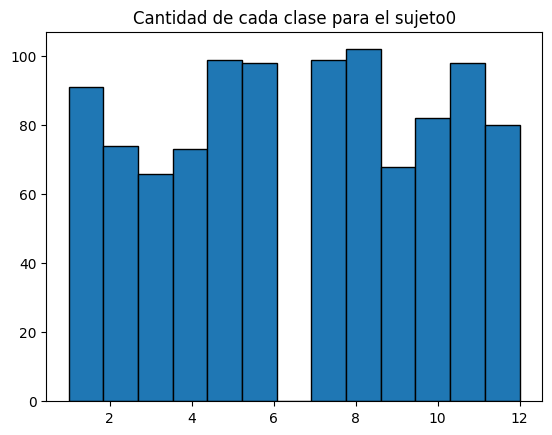

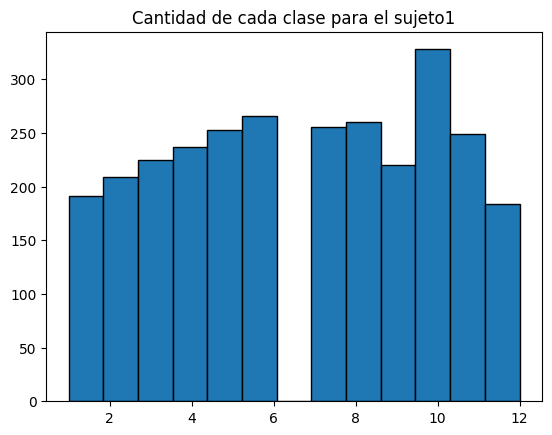

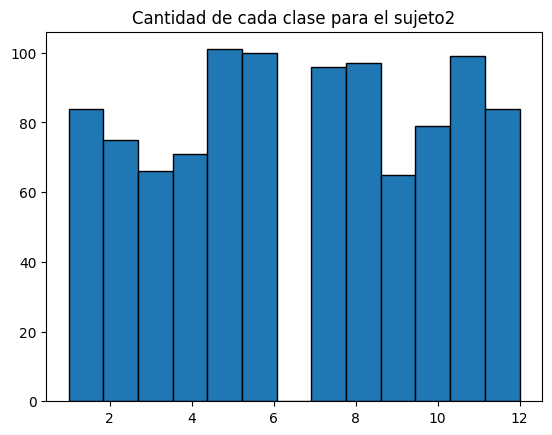

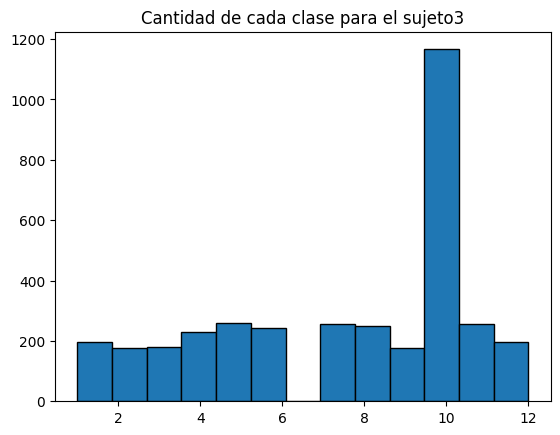

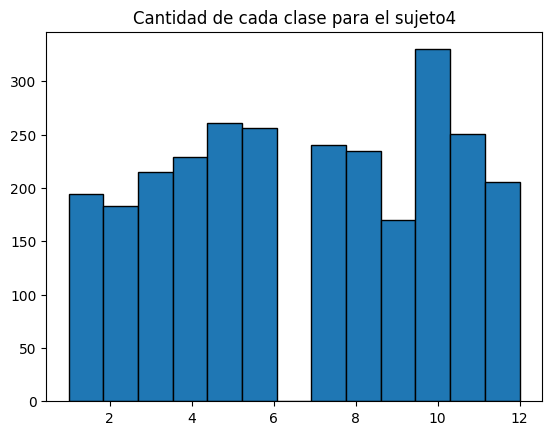

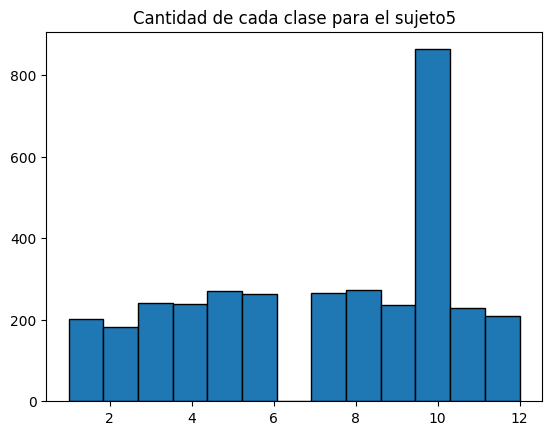

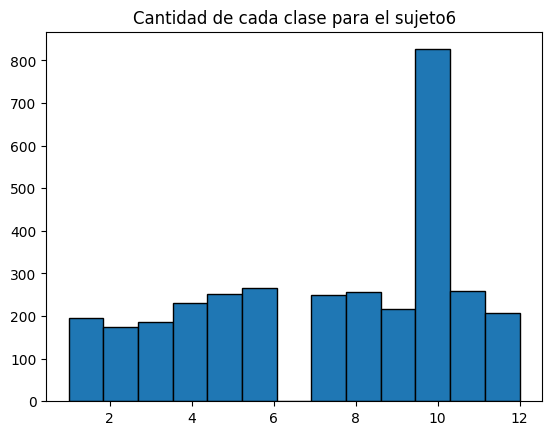

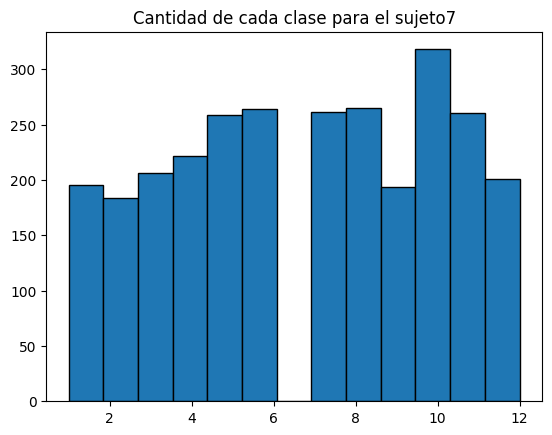

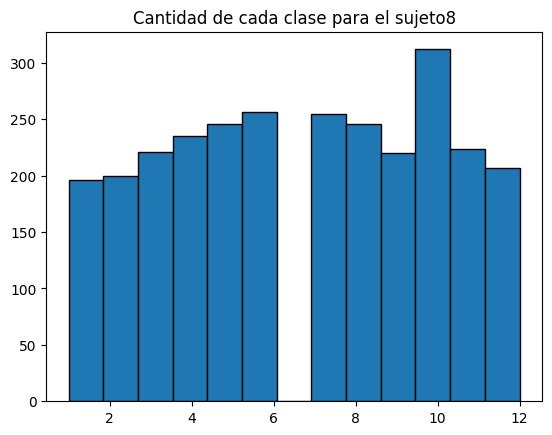

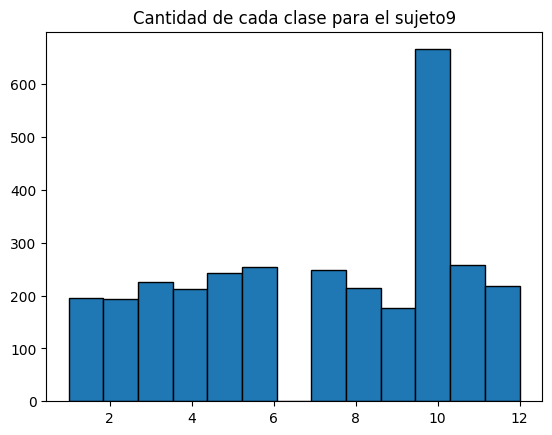

In [ ]:
def combine_features_labels_weights(features, sample_weights):
    inputs, labels = features
    return inputs, labels, sample_weights

for j in range(nOfSubjects): # ,
  label_j = list_label_x_sujeto[j]
  data_j = list_data_x_sujeto[j]

  input_sequence_length = 650 # Cada gesto dura 5s aprox, y el incremento es de 50ms

  label_dataset = tf.keras.utils.timeseries_dataset_from_array(
          data=label_j,  # excluimos los últimos target_sequence_length elementos de los datos
          targets=None,
          sequence_length=input_sequence_length,
          batch_size=None,   # multiplo de 8
          sequence_stride = 5
        )
  data_dataset = tf.keras.utils.timeseries_dataset_from_array(
          data=data_j,  # excluimos los últimos target_sequence_length elementos de los datos
          targets=None,
          sequence_length=input_sequence_length,
          batch_size=None,   # multiplo de 8
          sequence_stride = 5
        )

  secuencias_labels_list = []
  secuencias_data_list = []

  for x in label_dataset:
    secuencias_labels_list.append(x)

  for x in data_dataset:
    secuencias_data_list.append(x)

  selected_secuencias_labels_list = []
  selected_secuencias_labels_sec_list = []
  selected_secuencias_data_list = []

  contador = 0

  for i in range(len(secuencias_labels_list)):  # len(secuencias_labels_list)
    unique_values, counts = np.unique(secuencias_labels_list[i], return_counts=True)
    # Encontrar el valor que más se repite
    max_count_index = np.argmax(counts)
    most_frequent_value = unique_values[max_count_index]
    counts_most_frequent = counts[max_count_index]

    # if (((counts_most_frequent/len(secuencias_labels_list[i])) > 0.85)): #
    #   if (most_frequent_value==0):
    #     if (contador_reposos<80):
    #       contador_reposos += 1
    #       selected_secuencias_labels_list.append(most_frequent_value)
    #       selected_secuencias_data_list.append(secuencias_data_list[i])
    #   else:
    #     selected_secuencias_labels_list.append(most_frequent_value)
    #     selected_secuencias_data_list.append(secuencias_data_list[i])
    if (((counts_most_frequent/len(secuencias_labels_list[i])) == 1) and (most_frequent_value!=0)): #
      selected_secuencias_labels_list.append(most_frequent_value)
      selected_secuencias_labels_sec_list.append(list(np.array(secuencias_labels_list[i])-1))
      selected_secuencias_data_list.append(secuencias_data_list[i])

  # Visualizar cantidad de cada clase
  plt.figure()
  plt.hist(np.array(selected_secuencias_labels_list), bins=13, edgecolor='black')
  plt.title('Cantidad de cada clase para el sujeto'+str(j))

  selected_secuencias_labels_array = np.array(selected_secuencias_labels_list)
  selected_secuencias_labels_sec_array = np.array(selected_secuencias_labels_sec_list)

  # # Calcula los pesos de clase
  # class_weights = compute_class_weight(class_weight='balanced',
  #                                     classes=np.unique(selected_secuencias_labels_array), y=selected_secuencias_labels_array)
  # # Convierte los pesos a un diccionario
  # class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

  # print("Pesos de clase:", class_weights_dict)

  # Crear una matriz de pesos de la misma forma que y_train
  sample_weight = np.zeros(selected_secuencias_labels_array.shape)

  selected_secuencias_labels_array = selected_secuencias_labels_array - 1

  # Crear una matriz de pesos de la misma forma que y_train
  sample_weight_sec = np.zeros(selected_secuencias_labels_sec_array.shape)

  # Asignar los pesos de clase a cada timestep en la secuencia
  for i, class_weight in class_weights_dict.items():
      sample_weight[selected_secuencias_labels_array == i] = class_weight

  for m in range(sample_weight.shape[0]):
    for k in range(sample_weight_sec.shape[1]):
      sample_weight_sec[m, k] = sample_weight[m]


  # Verificar la forma de sample_weight
  print("Sample weight shape:", sample_weight_sec.shape)
  print("y_train shape:", selected_secuencias_labels_array.shape)

  # Armo los datasets
  sample_weight_j = tf.convert_to_tensor(sample_weight_sec, dtype=tf.float32)
  sample_weight_dataset = tf.data.Dataset.from_tensor_slices(sample_weight_j)
  # sample_weight_dataset = tf.data.Dataset.from_tensor_slices(sample_weight_j)

  # Convertir las listas en tensores de TensorFlow
  tensores = tf.stack(selected_secuencias_data_list)
  etiquetas = tf.convert_to_tensor(selected_secuencias_labels_sec_list)

  # print(sample_weight)
  # print(sample_weight_sec)

  # plt.figure()
  # plt.plot(sample_weight)
  # plt.plot(selected_secuencias_labels_array)

  # Crear un dataset a partir de los tensores y etiquetas
  input_dataset = tf.data.Dataset.from_tensor_slices((tensores, etiquetas))

  rnn_dataset_j = tf.data.Dataset.zip((input_dataset, sample_weight_dataset))

  rnn_dataset_j_def = rnn_dataset_j.map(combine_features_labels_weights)

  rnn_dataset_j_def.save("dataset_E1_weighted2_sin_reposo_crudo_sub"+str(j))

### Con sample weight y reposo

#### Cálculo de pesos

In [ ]:
for j in range(nOfSubjects): # ,
  label_j = list_label_x_sujeto[j]

  input_sequence_length = 650 # Cada gesto dura 5s aprox, y el incremento es de 50ms

  label_dataset = tf.keras.utils.timeseries_dataset_from_array(
          data=label_j,  # excluimos los últimos target_sequence_length elementos de los datos
          targets=None,
          sequence_length=input_sequence_length,
          batch_size=None,   # multiplo de 8
          sequence_stride = 5
        )

  secuencias_labels_list = []

  for x in label_dataset:
    secuencias_labels_list.append(x)

  selected_secuencias_labels_list = []

  contador_reposos = 0

  for i in range(len(secuencias_labels_list)):  # len(secuencias_labels_list)
    unique_values, counts = np.unique(secuencias_labels_list[i], return_counts=True)
    # Encontrar el valor que más se repite
    max_count_index = np.argmax(counts)
    most_frequent_value = unique_values[max_count_index]
    counts_most_frequent = counts[max_count_index]

    if (((counts_most_frequent/len(secuencias_labels_list[i])) > 0.85)): #
      if (most_frequent_value==0):
        if (contador_reposos<350):
          contador_reposos += 1
          selected_secuencias_labels_list.append(most_frequent_value)
          # selected_secuencias_data_list.append(secuencias_data_list[i])
      else:
        selected_secuencias_labels_list.append(most_frequent_value)


In [ ]:
selected_secuencias_labels_array = np.array(selected_secuencias_labels_list)
unique_values, counts = np.unique(selected_secuencias_labels_array, return_counts=True)
# Calcula los pesos de clase
class_weights = compute_class_weight(class_weight='balanced',
                                    classes=np.unique(selected_secuencias_labels_array), y=selected_secuencias_labels_array)
# Convierte los pesos a un diccionario
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

print("Pesos de clase:", class_weights_dict)

Pesos de clase: {0: 1.3635164835164835, 1: 1.1150251617541338, 2: 1.130878600072913, 3: 1.0397184514831574, 4: 1.0676303562209601, 5: 1.0025856496444732, 6: 0.9819563152896487, 7: 0.9942307692307693, 8: 1.07002414625733, 9: 1.1611454239191465, 10: 0.5320298430666324, 11: 0.9739403453689168, 12: 1.1583271097834205}


#### Guardar datasets

In [ ]:
def combine_features_labels_weights(features, sample_weights):
    inputs, labels = features
    return inputs, labels, sample_weights

for j in range(nOfSubjects): # ,
  label_j = list_label_x_sujeto[j]
  data_j = list_data_x_sujeto[j]

  input_sequence_length = 650 # Cada gesto dura 5s aprox, y el incremento es de 50ms

  label_dataset = tf.keras.utils.timeseries_dataset_from_array(
          data=label_j,  # excluimos los últimos target_sequence_length elementos de los datos
          targets=None,
          sequence_length=input_sequence_length,
          batch_size=None,   # multiplo de 8
          sequence_stride = 5
        )
  data_dataset = tf.keras.utils.timeseries_dataset_from_array(
          data=data_j,  # excluimos los últimos target_sequence_length elementos de los datos
          targets=None,
          sequence_length=input_sequence_length,
          batch_size=None,   # multiplo de 8
          sequence_stride = 5
        )

  secuencias_labels_list = []
  secuencias_data_list = []

  for x in label_dataset:
    secuencias_labels_list.append(x)

  for x in data_dataset:
    secuencias_data_list.append(x)

  selected_secuencias_labels_list = []
  selected_secuencias_labels_sec_list = []
  selected_secuencias_data_list = []

  contador_reposos = 0

  for i in range(len(secuencias_labels_list)):  # len(secuencias_labels_list)
    unique_values, counts = np.unique(secuencias_labels_list[i], return_counts=True)
    # Encontrar el valor que más se repite
    max_count_index = np.argmax(counts)
    most_frequent_value = unique_values[max_count_index]
    counts_most_frequent = counts[max_count_index]

    if (((counts_most_frequent/len(secuencias_labels_list[i])) > 0.85)): #
      if (most_frequent_value==0):
        if (contador_reposos<350):
          contador_reposos += 1
          selected_secuencias_labels_list.append(most_frequent_value)
          selected_secuencias_data_list.append(secuencias_data_list[i])
          selected_secuencias_labels_sec_list.append(list(np.array(secuencias_labels_list[i])))

      else:
        selected_secuencias_labels_list.append(most_frequent_value)
        selected_secuencias_data_list.append(secuencias_data_list[i])
        selected_secuencias_labels_sec_list.append(list(np.array(secuencias_labels_list[i])))

  # # Visualizar cantidad de cada clase
  # plt.figure()
  # plt.hist(np.array(selected_secuencias_labels_list), bins=13, edgecolor='black')
  # plt.title('Cantidad de cada clase para el sujeto'+str(j))

  # selected_secuencias_labels_array = np.array(selected_secuencias_labels_list)
  # selected_secuencias_labels_sec_array = np.array(selected_secuencias_labels_sec_list)

  # Crear una matriz de pesos de la misma forma que y_train
  sample_weight = np.zeros(selected_secuencias_labels_array.shape)

  # Crear una matriz de pesos de la misma forma que y_train
  sample_weight_sec = np.zeros(selected_secuencias_labels_sec_array.shape)

  # Asignar los pesos de clase a cada timestep en la secuencia
  for i, class_weight in class_weights_dict.items():
      sample_weight[selected_secuencias_labels_array == i] = class_weight

  for m in range(sample_weight.shape[0]):
    for k in range(sample_weight_sec.shape[1]):
      sample_weight_sec[m, k] = sample_weight[m]

  # Verificar la forma de sample_weight
  print("Sample weight shape:", sample_weight_sec.shape)
  print("y_train shape:", selected_secuencias_labels_array.shape)

  # Armo los datasets
  sample_weight_j = tf.convert_to_tensor(sample_weight_sec, dtype=tf.float32)
  sample_weight_dataset = tf.data.Dataset.from_tensor_slices(sample_weight_j)
  # sample_weight_dataset = tf.data.Dataset.from_tensor_slices(sample_weight_j)

  # Convertir las listas en tensores de TensorFlow
  tensores = tf.stack(selected_secuencias_data_list)
  etiquetas = tf.convert_to_tensor(selected_secuencias_labels_sec_list)

  # print(sample_weight)
  # print(sample_weight_sec)

  # plt.figure()
  # plt.plot(sample_weight)
  # plt.plot(selected_secuencias_labels_array)

  # Crear un dataset a partir de los tensores y etiquetas
  input_dataset = tf.data.Dataset.from_tensor_slices((tensores, etiquetas))

  rnn_dataset_j = tf.data.Dataset.zip((input_dataset, sample_weight_dataset))

  rnn_dataset_j_def = rnn_dataset_j.map(combine_features_labels_weights)

  rnn_dataset_j_def.save("dataset_E1_weighted_con_reposo_crudo_sub"+str(j))

## Sin reposo, con normalizacion

In [ ]:
# para cada sujeto armo un Dataset con las secuencias de datos y etiquetas
list_input_dataset_x_sujeto = []
list_labels_dataset_x_sujeto = []

for j in range(nOfSubjects):  #
  label_j = list_label_x_sujeto[j]
  data_j = list_data_x_sujeto[j]

  print(data_j.shape)
  means = np.zeros(data_j.shape[1], dtype = float)
  stds = np.zeros(data_j.shape[1], dtype = float)

  # a cada canal le resto la media de ese canal, y lo divido entre std de la que de mas alto

  # calculo medias y desviaciones estandar por
  for i in range(data_j.shape[1]):
    means[i] = np.mean(data_j[:, i])
    stds[i] = np.std(data_j[:, i])

  # estandarizacion personaizada
  for i in range(data_j.shape[1]):
    data_j[:, i] = (data_j[:, i] - means[i])/np.max(stds)

  input_sequence_length = 650 # Cada gesto dura 5s aprox, y el incremento es de 50ms

  label_dataset = tf.keras.utils.timeseries_dataset_from_array(
          data=label_j,  # excluimos los últimos target_sequence_length elementos de los datos
          targets=None,
          sequence_length=input_sequence_length,
          batch_size=None,   # multiplo de 8
          sequence_stride = 5
        )
  data_dataset = tf.keras.utils.timeseries_dataset_from_array(
          data=data_j,  # excluimos los últimos target_sequence_length elementos de los datos
          targets=None,
          sequence_length=input_sequence_length,
          batch_size=None,   # multiplo de 8
          sequence_stride = 5
        )

  secuencias_labels_list = []
  secuencias_data_list = []

  for x in label_dataset:
    secuencias_labels_list.append(x)

  for x in data_dataset:
    secuencias_data_list.append(x)

  selected_secuencias_labels_list = []
  selected_secuencias_data_list = []

  contador_reposos = 0

  for i in range(len(secuencias_labels_list)):  # len(secuencias_labels_list)
    unique_values, counts = np.unique(secuencias_labels_list[i], return_counts=True)
    # Encontrar el valor que más se repite
    max_count_index = np.argmax(counts)
    most_frequent_value = unique_values[max_count_index]
    counts_most_frequent = counts[max_count_index]

    if most_frequent_value==0:
      contador_reposos += 1

    if (((counts_most_frequent/len(secuencias_labels_list[i])) == 1) and (most_frequent_value != 0)):
      selected_secuencias_labels_list.append(np.array(secuencias_labels_list[i]))
      selected_secuencias_data_list.append(secuencias_data_list[i])

  selected_secuencias_labels_array = np.array(selected_secuencias_labels_list) - 1
  # Convertir las listas en tensores de TensorFlow
  tensores = tf.stack(selected_secuencias_data_list)
  etiquetas = tf.convert_to_tensor(list(selected_secuencias_labels_array))

  # # Visualizar cantidad de cada clase
  # plt.figure()
  # plt.hist(np.array(selected_secuencias_labels_list), bins=17, edgecolor='black')
  # plt.title('Cantidad de cada clase para el sujeto'+str(j))

  # Crear un dataset a partir de los tensores y etiquetas
  input_dataset = tf.data.Dataset.from_tensor_slices((tensores, etiquetas))

  input_dataset.save("dataset_E1_sin_reposo_crudo_norm_sub"+str(j)+"_seq_seq")

(129137, 16)
(147176, 16)
(130230, 16)
(150408, 16)
(147257, 16)
(150531, 16)
(149949, 16)
(146536, 16)
(146906, 16)
(148662, 16)
